In [1]:
!pip install datasets
!pip install nltk

from datasets import load_dataset
from datasets import Dataset

import numpy as np
import pandas as pd
import os
# Sarcasm Detection Model
from transformers import RobertaTokenizer
from transformers import RobertaForSequenceClassification
from transformers import TrainingArguments
from transformers import Trainer
# Linguistic Feature Analysis
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')
import re
from sklearn.feature_extraction.text import TfidfVectorizer
# visualizations
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 4.7 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.5.1
    Uninstalling fsspec-2025.5.1:
      Successfully uninstalled fsspec-2025.5.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.8.0 requires google-cloud-bigquery-storage<3.0.0,>=2.30.0, which is not installed.
cesium 0.12.4 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cuda-cupti-cu12 12.5.82 which is incompatible.
torch 2.6.0+cu124 re

2025-07-11 18:15:31.276660: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752257731.462663      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752257731.513936      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [3]:
reddit_tldr_dataset = load_dataset("webis/tldr-17", split="train")

README.md: 0.00B [00:00, ?B/s]

tldr-17.py: 0.00B [00:00, ?B/s]

dataset_infos.json: 0.00B [00:00, ?B/s]

The repository for webis/tldr-17 contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/webis/tldr-17.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N]  y


corpus-webis-tldr-17.zip:   0%|          | 0.00/3.14G [00:00<?, ?B/s]

Generating train split:   0%|          | 0/3848330 [00:00<?, ? examples/s]

Loading dataset shards:   0%|          | 0/38 [00:00<?, ?it/s]

## Preprocessing

### Selection of Subreddits

In [4]:
reddit_tldr_dataset = reddit_tldr_dataset.to_pandas()
top_subreddits = reddit_tldr_dataset['subreddit'].value_counts()[:20]
top_subreddits

subreddit
AskReddit              589947
relationships          352049
leagueoflegends        109307
tifu                    52219
relationship_advice     50416
trees                   47286
gaming                  43851
atheism                 43268
AdviceAnimals           40783
funny                   40171
politics                36518
pics                    35098
sex                     28806
WTF                     25781
explainlikeimfive       25482
todayilearned           25004
Fitness                 22694
IAmA                    22689
worldnews               22577
DotA2                   22405
Name: count, dtype: int64

#### Select diverse subreddits from different categories
- humor-oriented (expected high sarcasm): WTF
- political/news/debate (expected high sarcasm): worldnews
- factual/informational (low expected sarcasm): explainlikeimfive

In [5]:
sublist = ['explainlikeimfive', 'WTF', 'worldnews']
selected_subs = reddit_tldr_dataset[reddit_tldr_dataset['subreddit'].isin(sublist)]
selected_subs.head()

,author,body,normalizedBody,subreddit,subreddit_id,id,content,summary
55,Cypriotmenace,Think of it like mailing pages of a book to di...,Think of it like mailing pages of a book to di...,explainlikeimfive,t5_2sokd,c6dydfx,Think of it like mailing pages of a book to di...,"Always look for the highest seeded torrents, a..."
58,gloriously_offtopic,"This reminds me of this gal I met in Atlanta, ...","This reminds me of this gal I met in Atlanta, ...",WTF,t5_2qh61,c6effzd,"This reminds me of this gal I met in Atlanta, ...",Naked game of twister with friends.
93,pandasaurusrex,Eh. The problem is with circulation. Smoking...,Eh. The problem is with circulation. Smoking...,WTF,t5_2qh61,c6htvxh,Eh. The problem is with circulation. Smoking...,Please stop smoking?
95,_pupil_,"On the face of it, yeah, 700 grams is a lot. ...","On the face of it, yeah, 700 grams is a lot. ...",worldnews,t5_2qh13,c6hy9sx,"On the face of it, yeah, 700 grams is a lot. ...",middle aged white dudes who aren't sketching a...
244,senatorskeletor,"""Redistribution"" is short for ""redistribution ...","""Redistribution"" is short for ""redistribution ...",explainlikeimfive,t5_2sokd,c6whsmv,"Redistribution"" is short for ""redistribution o...",1) using the tax system to take money from the...


### Remove duplicates and unnecessary columns

In [ ]:
selected_subs.info()

In [6]:
selected_subs = selected_subs.drop(['body', 'normalizedBody'], axis=1)

duplicates_mask = selected_subs[['summary', 'subreddit']].duplicated()

num_duplicates = duplicates_mask.sum()
print(f'duplicate posts in the same subreddit: {num_duplicates}')

clean_selected_subs = selected_subs.drop_duplicates(subset=['summary', 'subreddit'])

clean_selected_subs.info()

duplicate posts in the same subreddit: 1221
<class 'pandas.core.frame.DataFrame'>
Index: 72619 entries, 55 to 3846182
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   author        72619 non-null  object
 1   subreddit     72619 non-null  object
 2   subreddit_id  72619 non-null  object
 3   id            72619 non-null  object
 4   content       72619 non-null  object
 5   summary       72619 non-null  object
dtypes: object(6)
memory usage: 3.9+ MB


#

## Predict Sarcasm Labels in Webis-TLDR-17

### Load fine-tuned model, tokenizer, trainer and training arguments

In [7]:
finetuned_model = RobertaForSequenceClassification.from_pretrained("/kaggle/input/roberta_finetuned_sarc2/transformers/default/1")

tokenizer = RobertaTokenizer.from_pretrained("/kaggle/input/roberta_finetuned_sarc2/transformers/default/1")

training_args = TrainingArguments(
    output_dir="/kaggle/input/roberta_finetuned_sarc2/transformers/default/1",
    per_device_eval_batch_size=32,
)

trainer = Trainer(
    model=finetuned_model,
    args=training_args,
    processing_class=tokenizer
)

In [8]:
clean_selected_subs = Dataset.from_pandas(clean_selected_subs)

In [9]:
def tokenize_inputs(inputs):
    return tokenizer(inputs['summary'], truncation=True, padding='max_length', max_length=64)

tokenized_summaries = clean_selected_subs.map(tokenize_inputs, batched=True)

Map:   0%|          | 0/72619 [00:00<?, ? examples/s]

In [10]:
def tokenize_inputs(inputs):
    return tokenizer(inputs['content'], truncation=True, padding='max_length', max_length=64)

tokenized_comments = clean_selected_subs.map(tokenize_inputs, batched=True)

Map:   0%|          | 0/72619 [00:00<?, ? examples/s]

In [11]:
os.environ["WANDB_DISABLED"] = "true"
os.environ["WANDB_MODE"] = "disabled"

### Sarcasm Predictions

In [12]:
preds = trainer.predict(tokenized_summaries)
labels = preds.predictions.argmax(1)

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


In [13]:
preds_comments = trainer.predict(tokenized_comments)
labels_comments = preds_comments.predictions.argmax(1)

In [14]:
tokenized_summaries = tokenized_summaries.add_column("sarcasm_prediction", labels)

In [15]:
tokenized_comments = tokenized_comments.add_column("sarcasm_prediction", labels_comments)

### Relative amount of sarcasm per subreddit

In [16]:
# in tldrs
labeled_summaries = tokenized_summaries.to_pandas()
grouped_labeled_summaries = labeled_summaries.groupby('subreddit')['sarcasm_prediction'].agg(['size', 'mean', 'sum'])
grouped_labeled_summaries.sort_values(by='sum', ascending=False).head(10)

,size,mean,sum
subreddit,,,
WTF,25286,0.149173,3772
worldnews,22151,0.168074,3723
explainlikeimfive,25182,0.117783,2966


In [17]:
# in full comments
labeled_comments = tokenized_comments.to_pandas()
grouped_labeled_comments = labeled_comments.groupby('subreddit')['sarcasm_prediction'].agg(['size', 'mean', 'sum'])
grouped_labeled_comments.sort_values(by='sum', ascending=False).head(10)

,size,mean,sum
subreddit,,,
worldnews,22151,0.089748,1988
WTF,25286,0.071304,1803
explainlikeimfive,25182,0.039393,992


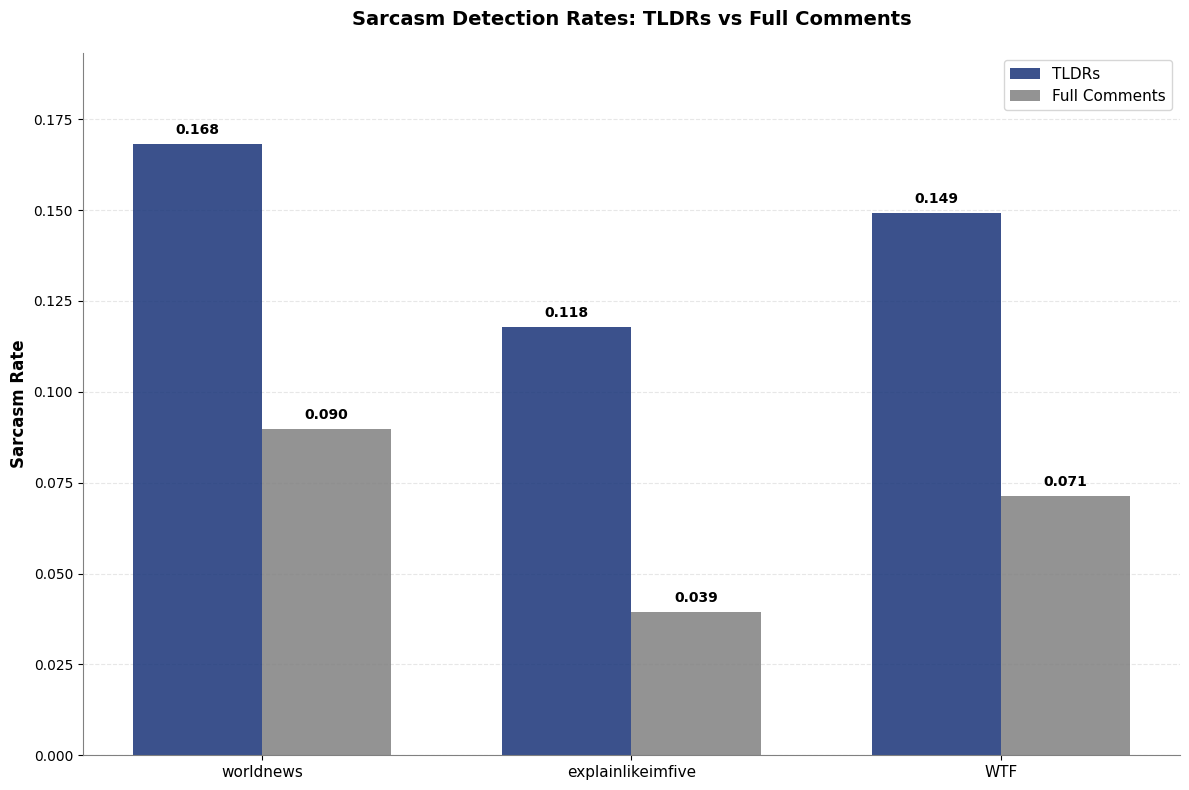

In [23]:
df_plot = pd.DataFrame({
    'subreddit': grouped_labeled_summaries.index,
    'summary_rate': grouped_labeled_summaries['mean'],
    'comment_rate': grouped_labeled_comments['mean']
})

df_plot['sum'] = grouped_labeled_summaries.sum(axis=1) + grouped_labeled_comments.sum(axis=1)
df_plot = df_plot.sort_values('sum').reset_index(drop=True)


fig, ax = plt.subplots(figsize=(12, 8))

bar_width = 0.35
x_pos = np.arange(len(df_plot))

bars1 = ax.bar(x_pos - bar_width/2, df_plot['summary_rate'], bar_width, 
               label='TLDRs', color='#183378', alpha=0.85)
bars2 = ax.bar(x_pos + bar_width/2, df_plot['comment_rate'], bar_width,
               label='Full Comments', color='gray', alpha=0.85)

ax.set_ylabel('Sarcasm Rate', fontsize=12, fontweight='bold')
ax.set_title('Sarcasm Detection Rates: TLDRs vs Full Comments', 
             fontsize=14, fontweight='bold', pad=20)
ax.set_xticks(x_pos)
ax.set_xticklabels(df_plot['subreddit'], fontsize=11)

def add_value_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.002,
                f'{height:.3f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

add_value_labels(bars1)
add_value_labels(bars2)

ax.legend(fontsize=11, loc='upper right')

ax.grid(axis='y', alpha=0.3, linestyle='--')
ax.set_axisbelow(True)

ax.set_ylim(0, max(max(df_plot['summary_rate']), max(df_plot['comment_rate'])) * 1.15)

plt.tight_layout()

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_color('gray')
ax.spines['bottom'].set_color('gray')

plt.show()

In [ ]:
#pd.set_option('display.max_colwidth', None)
sarc_summaries = labeled_summaries.loc[labeled_summaries['sarcasm_prediction'] == 1]
sarc_summaries['summary'].head(10)

In [ ]:
sarc_comments = labeled_comments.loc[labeled_comments['sarcasm_prediction'] == 1]
sarc_comments['content'].head(10)

In [ ]:
pd.set_option('display.max_colwidth', None)
sarc_comments['content'].loc[sarc_comments['id'] == 'cm693hw']

In [ ]:
# wordcloud of characteristic sarcastic expressions

vectorizer = TfidfVectorizer(max_features=1000, stop_words='english', ngram_range=(1, 2))
tfidf_matrix = vectorizer.fit_transform(labeled_comments['content'])

feature_names = vectorizer.get_feature_names_out()

sarcastic_mask = labeled_comments[labeled_comments['sarcasm_prediction'] == 1].index
non_sarcastic_mask = labeled_comments[labeled_comments['sarcasm_prediction'] == 0].index

sarcastic_tfidf = tfidf_matrix[sarcastic_mask]
non_sarcastic_tfidf = tfidf_matrix[non_sarcastic_mask]

sarcastic_scores = sarcastic_tfidf.mean(axis=0).A1
non_sarcastic_scores = non_sarcastic_tfidf.mean(axis=0).A1

sarcastic_distinctiveness = sarcastic_scores - non_sarcastic_scores

# get top distinctive sarcastic words
word_scores = list(zip(feature_names, sarcastic_distinctiveness))
word_scores.sort(key=lambda x: x[1], reverse=True)

top_sarcastic_words = {word: score for word, score in word_scores[:100] if score > 0}

wordcloud = WordCloud(
    background_color='white',
    width=800,
    height=400
).generate_from_frequencies(top_sarcastic_words)

plt.figure(figsize=(16, 9))
plt.imshow(wordcloud)

In [ ]:
#sarc_summaries.drop(columns=[''])

In [ ]:
sarc_summaries[sarc_summaries['id'] == 'c8tp1c1']['summary']

In [ ]:
sarc_summaries.to_csv('/kaggle/working/webis_sarc_summaries.csv', index = False)

In [ ]:
sarc_comments.to_csv('/kaggle/working/webis_sarc_comments.csv', index = False)

## Sarcasm Analysis: Sentiment Incongruity and Emphatic Puntuation Density

### 1. Sentiment Incongruity

In [24]:
!pip install nltk
import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [25]:
def calculate_sentiment_incongruity(text):
    """
    Calculates a sentiment incongruity score for a given text using VADER.
    A higher score indicates a greater mix of positive and negative sentiment,
    which can be a sign of sarcasm.
    """
    analyzer = SentimentIntensityAnalyzer()
    vs = analyzer.polarity_scores(text)

    # incongruity score: product of positive and negative scores (higher when positive and negative sentiments are both expressed)
    incongruity = vs['pos'] * vs['neg']
    return incongruity

In [26]:
# sentiment incongruity in sarcastic and non-sarcastic comments

labeled_comments['sentiment_incongruity_score'] = labeled_comments['content'].apply(calculate_sentiment_incongruity)

# average incongruity per subreddit
avg_incongruity_per_category = labeled_comments.groupby('sarcasm_prediction')['sentiment_incongruity_score'].mean().reset_index()
print("\nAverage Sentiment Incongruity in sarc and non-sarc comments:")
print(avg_incongruity_per_category)


Average Sentiment Incongruity in sarc and non-sarc comments:
   sarcasm_prediction  sentiment_incongruity_score
0                   0                     0.007501
1                   1                     0.009473


### 2. Emphatic punctuation

In [27]:
def calculate_emphatic_punctuation_density(text):
    """
    Calculates a the punctuation density by counting specified punctuation characters
    and normalizing the sum by the word count of the text. 
    """
    if not text:
        return 0.0

    emphatic_chars = ['!', '?', '"'] # add more characters?
    punctuation_count = sum(text.count(char) for char in emphatic_chars)
    words = text.split() # normalize by total word count
    num_words = len(words)
    
    if num_words == 0:
        return 0.0
    # Density: punctuation count per word
    return punctuation_count / num_words

In [28]:
labeled_comments['punctuation_density'] = labeled_comments['content'].apply(calculate_emphatic_punctuation_density)

punctuation_density_per_category = labeled_comments.groupby('sarcasm_prediction')['punctuation_density'].mean().reset_index()
punctuation_density_per_category

,sarcasm_prediction,punctuation_density
0,0,0.013216
1,1,0.020804


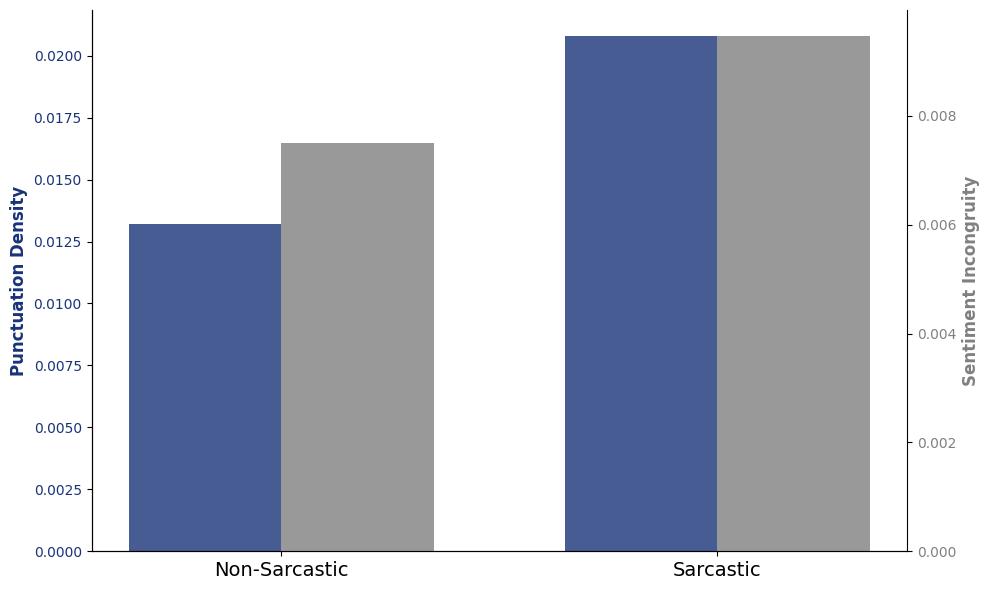

In [33]:
categories = ['Non-Sarcastic', 'Sarcastic']
sentiment_incongruity = avg_incongruity_per_category['sentiment_incongruity_score']
punctuation_density = punctuation_density_per_category['punctuation_density']

x = np.arange(len(categories))
width = 0.35

fig, ax1 = plt.subplots(figsize=(10, 6))

bars1 = ax1.bar(x - width/2, punctuation_density, width, label='Punctuation Density', 
                color='#183378', alpha=0.8)
ax1.set_ylabel('Punctuation Density', fontsize=12, fontweight='bold', color='#183378')
ax1.tick_params(axis='y', labelcolor='#183378')

ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

ax2 = ax1.twinx()
bars2 = ax2.bar(x + width/2, sentiment_incongruity, width, label='Sentiment Incongruity', 
                color='gray', alpha=0.8)
ax2.set_ylabel('Sentiment Incongruity', fontsize=12, fontweight='bold', color='gray')
ax2.tick_params(axis='y', labelcolor='gray')

ax2.spines['top'].set_visible(False)

ax1.set_xticks(x)
ax1.set_xticklabels(categories, fontsize=14)

plt.tight_layout()
plt.show()